## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

#%matplotlib qt
def init_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    shape = (0,0)
    for fname in images:
        img = mpimg.imread(fname)
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        shape = gray.shape[::-1]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
    global ret_calib, mtx, dist, rvecs, tvec
    ret_calib, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
#cv2.destroyAllWindows()


## And so on and so forth...

In [2]:
def test_calibration_on_image() :
    img = mpimg.imread('camera_cal/calibration1.jpg')
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_undistorted_calib1.png',img_undistorted)

In [3]:
def get_calibrated_image(image) :
    return cv2.undistort(image, mtx, dist, None, mtx)

In [842]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(gray, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelxory = cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelxory = np.absolute(sobelxory)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxory/np.max(abs_sobelxory))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    abs_sobel = np.absolute(np.sqrt(np.square(sobelx) + np.square(sobely)))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abssobelx = np.absolute(sobelx)
    abssobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    ang = np.arctan2(abssobely, abssobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(ang)
    binary_output[(ang >= thresh[0]) & (ang <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

#Only a helper method
def pipeline_debug_test(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    ksize = 9
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 160
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary,s_binary,sxbinary

def pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 160
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    #combined_binary = region_of_interest(combined_binary, vertices)
    
    return combined_binary

def get_thresholded_image(image) :
    # Read in an image and grayscale it
    image = get_calibrated_image(image)
    color_binary = pipeline(image)
    #plt.show()
    return color_binary

In [843]:
def test_thresholded_image(thresholded_image) :
    #For now just saving the image but should do some testing whether it worked as we wanted it to
    cv2.imwrite('output_thresholded_1.png', thresholded_image)

In [844]:
def prepare_perspective_transform(image) :
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    dst = get_calibrated_image(image)
    test_i = np.copy(dst)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    img = dst
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value

    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    #print(img_size)
    src = np.float32([[580,460],[710,460],[1150,720],[150,720]])
    pts = np.array(src, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(test_i,[pts],True,(0,255,255))
    dest = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    Minv = cv2.getPerspectiveTransform(src, dest)
    Rev_minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(dst, Minv, (gray.shape[1], gray.shape[0]), flags=cv2.INTER_LINEAR)
    
    pts_d = np.array(dest, np.int32)
    pts_d = pts_d.reshape((-1,1,2))
    cv2.polylines(warped,[pts_d],True,(0,255,255))
    
    return Minv, Rev_minv

In [845]:
def init_perspective_transform(image):
    global persp_min, rev_persp_min
    persp_min, rev_persp_min = prepare_perspective_transform(image)

In [846]:
def get_perspective_transformed_img(image):
    img = get_calibrated_image(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    warped = cv2.warpPerspective(img, persp_min, (gray.shape[1], gray.shape[0]), flags=cv2.INTER_LINEAR)
    #plt.show()
    return warped

In [847]:
def test_perspective_transform(image):
    persp_img = get_perspective_transformed_img(image)
    #plt.imshow(persp_img)
    #plt.show()

In [848]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids

def sliding_window_analysis(warped):
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        print('Error.........')
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

In [849]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts, x_dir):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = x_dir/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

def find_pos_curve(ploty, left_fitx, right_fitx, binary_warped, image) :
    image = get_calibrated_image(image)
    curvature  = find_curvature(ploty, left_fitx)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, rev_persp_min, (image.shape[1], image.shape[0]))
    
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts, image.shape[1])

    
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    return result

def window_based_line_det(binary_warped, img):
    image = get_calibrated_image(img)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.show()
    
    return ploty, left_fitx, right_fitx, binary_warped

In [850]:
def init_pipeline():
    init_calibration()
    test_calibration_on_image()

test1


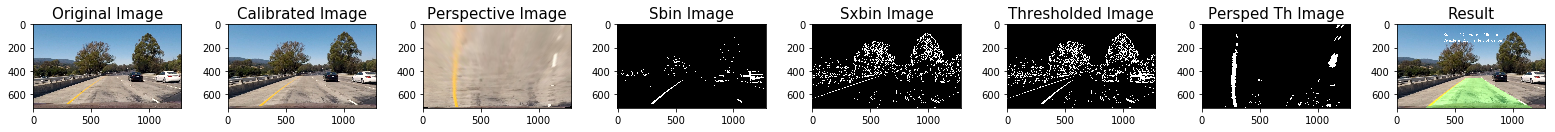

test2


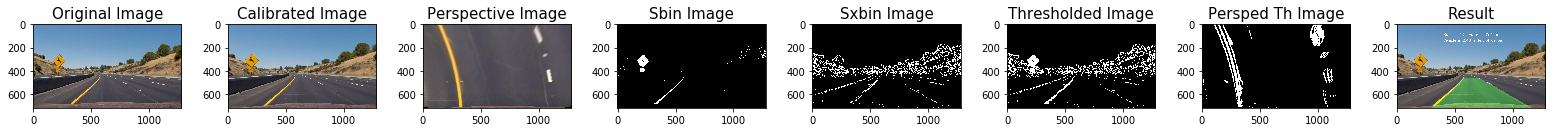

test3


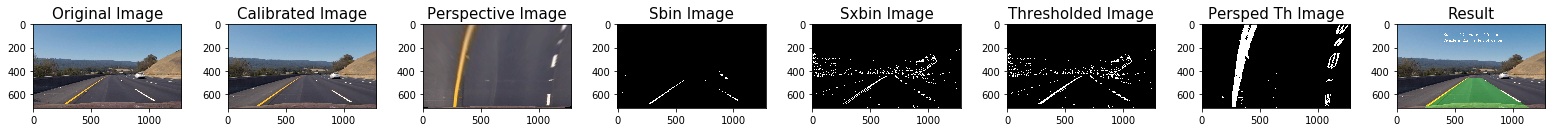

test4


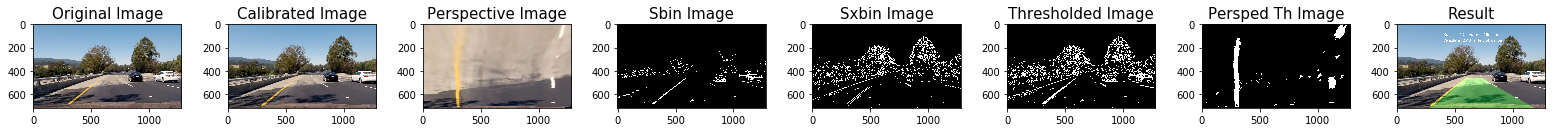

test5


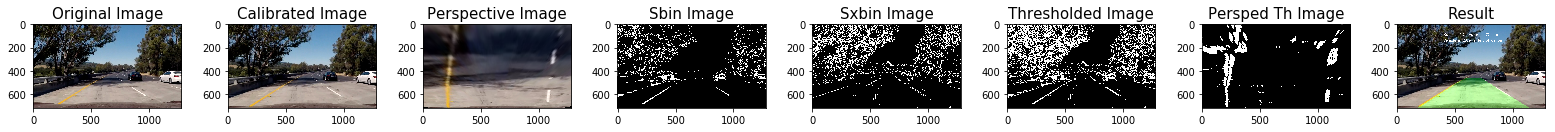

test6


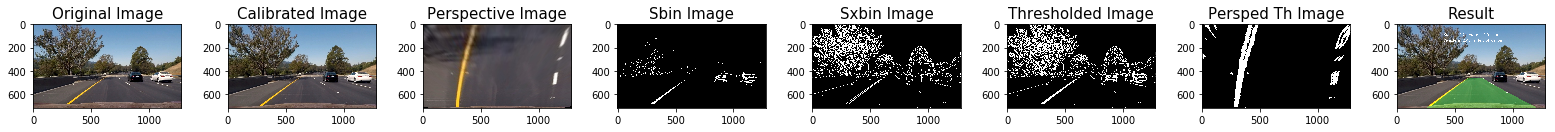

In [851]:
init_pipeline()
for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    fname_split = fname.split(".")[0]
    fname_split = fname_split.split("/")[1]
    print(fname_split)
    image = mpimg.imread(fname)
    
    calibed_img = get_calibrated_image(image)
    init_perspective_transform(image)
    persped_image = get_perspective_transformed_img(image)
    combined, sbin, sxbin = pipeline_debug_test(image)    
    thresholded_image = get_thresholded_image(image)
    persp_thresholded = cv2.warpPerspective(thresholded_image, persp_min, (thresholded_image.shape[1], thresholded_image.shape[0]), flags=cv2.INTER_LINEAR)
    ploty, left_fitx, right_fitx, binary_warped = window_based_line_det(persp_thresholded, image)
    result = find_pos_curve(ploty, left_fitx, right_fitx, binary_warped, image)

    fontz = 15
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1, 8, figsize=(21, 8))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=fontz)

    ax2.imshow(calibed_img)
    ax2.set_title('Calibrated Image', fontsize=fontz)
    cv2.imwrite('output_images/'+fname_split+'_calib.jpg', calibed_img)

    ax3.imshow(persped_image)
    ax3.set_title('Perspective Image', fontsize=fontz)
    cv2.imwrite('output_images/'+fname_split+'_persped.jpg', persped_image)

    ax4.imshow(sbin, cmap='gray')
    ax4.set_title('Sbin Image', fontsize=fontz)    
    ax5.imshow(sxbin, cmap='gray')
    ax5.set_title('Sxbin Image', fontsize=fontz)
    ax6.imshow(combined, cmap='gray')
    ax6.set_title('Thresholded Image', fontsize=fontz)

    ax7.imshow(persp_thresholded, cmap='gray')
    ax7.set_title('Persped Th Image', fontsize=fontz)

    ax8.imshow(result)
    ax8.set_title('Result', fontsize=fontz)
    cv2.imwrite('output_images/'+fname_split+'_final.jpg', result)
    
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [834]:
def pipeline_run(test_image):
    init_perspective_transform(test_image)
    test_perspective_transform(test_image)    
    thresholded_image = get_thresholded_image(test_image)
    persp_thresholded = cv2.warpPerspective(thresholded_image, persp_min, (thresholded_image.shape[1], thresholded_image.shape[0]), flags=cv2.INTER_LINEAR)
    ploty, left_fitx, right_fitx, binary_warped = window_based_line_det(persp_thresholded, test_image)
    result = find_pos_curve(ploty, left_fitx, right_fitx, binary_warped, test_image)
    return result

In [840]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
init_pipeline()
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline_run) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 24%|██▍       | 303/1261 [02:23<08:11,  1.95it/s]


 48%|████▊     | 605/1261 [05:12<06:51,  1.60it/s]


 72%|███████▏  | 907/1261 [07:49<03:36,  1.63it/s]


 96%|█████████▌| 1205/1261 [10:12<00:37,  1.49it/s]


100%|█████████▉| 1260/1261 [10:44<00:00,  2.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 11min, sys: 1min 14s, total: 12min 14s
Wall time: 10min 45s


In [841]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [186]:
import os
def video_to_frames(video, path_output_dir):
    # extract frames from a video and save to directory as 'x.png' where 
    # x is the frame index
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, '%d.png') % count, image)
            count += 1
        else:
            break
    cv2.destroyAllWindows()
    vidcap.release()

video_to_frames('./project_video.mp4', './temp_frames')